In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# Authors: Maxime Goffart and Olivier Joris

import os
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.impute import KNNImputer
from scipy import stats
from scipy.signal import find_peaks
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def load_data(data_path):
    """
    Load the data for the classifer.
    Method given with the assignment. Authors: Antonio Sutera & Yann Claes.

    Argument:
    ---------
    - `data_path`: Path to the data folder.
    """

    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_train, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_train[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_train = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_train size: {}.'.format(X_train.shape))
    print('y_train size: {}.'.format(y_train.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_train, y_train, X_test

def write_submission(y, where, submission_name='toy_submission.csv'):
    """
    Load the data for the classifer.
    Method given with the assignment. Authors: Antonio Sutera & Yann Claes.

    Argument:
    ---------
    - `data_path`: Path to the data folder.
    """

    os.makedirs(where, exist_ok=True)

    SUBMISSION_PATH = os.path.join(where, submission_name)
    if os.path.exists(SUBMISSION_PATH):
        os.remove(SUBMISSION_PATH)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(SUBMISSION_PATH, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print('Submission {} saved in {}.'.format(submission_name, SUBMISSION_PATH))

In [2]:
def feature_extraction(X_train, X_test, data_path):
    """
    Feature extraction.

    Arguments:
    ----------
    - `X_train`: Inputs of LS.
    - `X_test`: Inputs of TS.
    - `data_path`: Path to the data folder.
    
    Return:
    -------
    Inputs of LS and TS after feature extraction.
    """
    
    FEATURES = range(2, 33)
    THREE_DIM_FEATURES = [4, 7, 10, 14, 17, 20, 24, 27, 30]
    ONE_DIM_FEATURES = [2, 3, 13, 23]
    N_TIME_SERIES = 3500
    N_ONE_DIM_ATTRIB = 38
    N_THREE_DIM_ATTRIB = 42
    
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    
    # + 1 for the subject id
    new_X_train = np.zeros((N_TIME_SERIES, N_ONE_DIM_ATTRIB * 4 + N_THREE_DIM_ATTRIB * 27 + 1))
    new_X_test = np.zeros((N_TIME_SERIES, N_ONE_DIM_ATTRIB * 4 + N_THREE_DIM_ATTRIB * 27 + 1))
    
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    TS_subject_id = np.loadtxt(os.path.join(TS_path, 'subject_Id.txt'))
    
    # subject id
    new_X_train[:, 0] = LS_subject_id
    new_X_test[:, 0] = TS_subject_id
        
    for i in range(N_TIME_SERIES):
        index = 0
        for f in FEATURES:
            if f in ONE_DIM_FEATURES:
                index += 1
                # mean
                new_X_train[i][index] = np.mean(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.mean(X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # stddev
                new_X_train[i][index] = np.std(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.std(X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # median
                new_X_train[i][index] = np.median(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.median(X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # min
                new_X_train[i][index] = np.min(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.min(X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # max
                new_X_train[i][index] = np.max(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.max(X_test[i][(f-2)*512:(f-2+1)*512])
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(X_train[i][(f-2)*512:(f-2+1)*512]))
                new_X_test[i][index] = np.argmax(np.abs(X_test[i][(f-2)*512:(f-2+1)*512]))
                
                index += 1
                # index of argmin 
                new_X_train[i][index] = np.argmin(np.abs(X_train[i][(f-2)*512:(f-2+1)*512]))
                new_X_test[i][index] = np.argmin(np.abs(X_test[i][(f-2)*512:(f-2+1)*512]))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(X_train[i][(f-2)*512:(f-2+1)*512])) - np.argmin(np.abs(X_train[i][(f-2)*512:(f-2+1)*512])))
                new_X_test[i][index] = abs(np.argmax(np.abs(X_test[i][(f-2)*512:(f-2+1)*512])) - np.argmin(np.abs(X_test[i][(f-2)*512:(f-2+1)*512])))

                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # range
                new_X_train[i][index] = np.max(X_train[i][(f-2)*512:(f-2+1)*512]) - np.min(X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.max(X_test[i][(f-2)*512:(f-2+1)*512]) - np.min(X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, X_test[i][(f-2)*512:(f-2+1)*512])

                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/512, 0, X_train[i][(f-2)*512:(f-2+1)*512])
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/512, 0, X_test[i][(f-2)*512:(f-2+1)*512])
                
                # move to frequency domain using half the timesteps to not introduce bias
                x_train_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, X_train[i][(f-2)*512:(f-2+1)*512])
                x_test_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, X_test[i][(f-2)*512:(f-2+1)*512])
                
                index += 1
                # mean
                new_X_train[i][index] = np.mean(x_train_freq)
                new_X_test[i][index] = np.mean(x_test_freq)

                index += 1
                # stddev
                new_X_train[i][index] = np.std(x_train_freq)
                new_X_test[i][index] = np.std(x_test_freq)

                index += 1
                # median
                new_X_train[i][index] = np.median(x_train_freq)
                new_X_test[i][index] = np.median(x_test_freq)

                index += 1
                # min
                new_X_train[i][index] = np.min(x_train_freq)
                new_X_test[i][index] = np.min(x_test_freq)

                index += 1
                # max
                new_X_train[i][index] = np.max(x_train_freq)
                new_X_test[i][index] = np.max(x_test_freq)
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(x_train_freq))
                new_X_test[i][index] = np.argmax(np.abs(x_test_freq))
                
                index += 1
                # index of argmin 
                new_X_train[i][index] = np.argmin(np.abs(x_train_freq))
                new_X_test[i][index] = np.argmin(np.abs(x_test_freq))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(x_train_freq)) - np.argmin(np.abs(x_train_freq)))
                new_X_test[i][index] = abs(np.argmax(np.abs(x_test_freq)) - np.argmin(np.abs(x_test_freq)))

                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, x_test_freq)

                index += 1
                # range
                new_X_train[i][index] = np.max(x_train_freq) - np.min(x_train_freq)
                new_X_test[i][index] = np.max(x_test_freq) - np.min(x_test_freq)

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, x_test_freq)

                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, x_test_freq)

                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, x_test_freq)

                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, x_test_freq)

                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, x_test_freq)

                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, x_test_freq)

                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, x_test_freq)

                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, x_test_freq)

                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, x_test_freq)

    
            elif f in THREE_DIM_FEATURES:
                comp_x_train = X_train[i][(f-2)*512:((f-2)+1)*512]
                comp_y_train = X_train[i][((f-2)+1)*512:((f-2)+2)*512]
                comp_z_train = X_train[i][((f-2)+2)*512:((f-2)+3)*512]
                
                comp_x_test = X_test[i][(f-2)*512:((f-2)+1)*512]
                comp_y_test = X_test[i][((f-2)+1)*512:((f-2)+2)*512]
                comp_z_test = X_test[i][((f-2)+2)*512:((f-2)+3)*512]
            
                index += 1
                # mean
                new_X_train[i][index] = np.mean(comp_x_train)
                new_X_test[i][index] = np.mean(comp_x_test)
                
                index += 1
                # mean 
                new_X_train[i][index] = np.mean(comp_y_train)
                new_X_test[i][index] = np.mean(comp_y_test)
                
                index += 1
                # mean 
                new_X_train[i][index] = np.mean(comp_z_train)
                new_X_test[i][index] = np.mean(comp_z_test)

                index += 1
                # stddev 
                new_X_train[i][index] = np.std(comp_x_train)
                new_X_test[i][index] = np.std(comp_x_test)
                
                index += 1
                # stddev 
                new_X_train[i][index] = np.std(comp_y_train)
                new_X_test[i][index] = np.std(comp_y_test)
                
                index += 1
                # stddev
                new_X_train[i][index] = np.std(comp_z_train)
                new_X_test[i][index] = np.std(comp_z_test)

                index += 1
                # median
                new_X_train[i][index] = np.median(comp_x_train)
                new_X_test[i][index] = np.median(comp_x_test)
                
                index += 1
                # median
                new_X_train[i][index] = np.median(comp_y_train)
                new_X_test[i][index] = np.median(comp_y_test)
                
                index += 1
                # median
                new_X_train[i][index] = np.median(comp_z_train)
                new_X_test[i][index] = np.median(comp_z_test)

                index += 1
                # min
                new_X_train[i][index] = np.min(comp_x_train)
                new_X_test[i][index] = np.min(comp_x_test)
                
                index += 1
                # min
                new_X_train[i][index] = np.min(comp_y_train)
                new_X_test[i][index] = np.min(comp_y_test)
                
                index += 1
                # min
                new_X_train[i][index] = np.min(comp_z_train)
                new_X_test[i][index] = np.min(comp_z_test)

                index += 1
                # max
                new_X_train[i][index] = np.max(comp_x_train)
                new_X_test[i][index] = np.max(comp_x_test)
                
                index += 1
                # max
                new_X_train[i][index] = np.max(comp_y_train)
                new_X_test[i][index] = np.max(comp_y_test)
                
                index += 1
                # max
                new_X_train[i][index] = np.max(comp_z_train)
                new_X_test[i][index] = np.max(comp_z_test)
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_x_train))
                new_X_test[i][index] = np.argmax(np.abs(comp_x_test))
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_y_train))
                new_X_test[i][index] = np.argmax(np.abs(comp_y_test))
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_z_train))
                new_X_test[i][index] = np.argmax(np.abs(comp_z_test))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_x_train))
                new_X_test[i][index] = np.argmin(np.abs(comp_x_test))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_y_train))
                new_X_test[i][index] = np.argmin(np.abs(comp_y_test))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_z_train))
                new_X_test[i][index] = np.argmin(np.abs(comp_z_test))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_x_train) - np.argmin(np.abs(comp_x_train))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_x_test)) - np.argmin(np.abs(comp_x_test)))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_y_train) - np.argmin(np.abs(comp_y_train))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_y_test)) - np.argmin(np.abs(comp_y_test)))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_z_train) - np.argmin(np.abs(comp_z_train))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_z_test)) - np.argmin(np.abs(comp_z_test)))

                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_x_test)

                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_y_test)
                
                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_z_test)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_x_train) - np.min(comp_x_train)
                new_X_test[i][index] = np.max(comp_x_test) - np.min(comp_x_test)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_y_train) - np.min(comp_y_train)
                new_X_test[i][index] = np.max(comp_y_test) - np.min(comp_y_test)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_z_train) - np.min(comp_z_train)
                new_X_test[i][index] = np.max(comp_z_test) - np.min(comp_z_test)

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_x_test)

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_y_test)
                
                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_z_test)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_x_test)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_y_test)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_z_test)

                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_x_test)
                
                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_y_test)
                
                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_z_test)

                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_x_test)
                
                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_y_test)
                
                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_z_test)

                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_x_test)
                
                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_y_test)
                
                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_z_test)

                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_x_test)
                
                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_y_test)
                
                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_z_test)

                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_x_test)
                
                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_y_test)
                
                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_z_test)

                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_x_test)
                
                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_y_test)
                
                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_z_test)

                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_x_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_x_test)
                
                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_y_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_y_test)
                
                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_z_train)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_z_test)
          
                index += 1
                # resultant of the average 
                new_X_train[i][index] = (np.mean(comp_x_train)**2 + np.mean(comp_y_train)**2 + np.mean(comp_z_train)**2)**0.5                
                new_X_test[i][index] = (np.mean(comp_x_test)**2 + np.mean(comp_y_test)**2 + np.mean(comp_z_test)**2)**0.5
    
                index += 1
                # signal magnitude
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_x_train) + np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_y_train) + np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_z_train)
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_x_test) + np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_y_test) + np.apply_along_axis(lambda x: np.sum(abs(x))/512, 0, comp_z_test)
    
                # move to frequency domain using half the timesteps to not introduce bias
                comp_x_train_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_x_train)
                comp_x_test_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_x_test)
                
                comp_y_train_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_y_train)
                comp_y_test_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_y_test)
                
                comp_z_train_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_z_train)
                comp_z_test_freq = np.apply_along_axis(lambda x: np.abs(np.fft.fft(x))[0:255], 0, comp_z_test)
                
                index += 1
                # mean
                new_X_train[i][index] = np.mean(comp_x_train_freq)
                new_X_test[i][index] = np.mean(comp_x_test_freq)
                
                index += 1
                # mean 
                new_X_train[i][index] = np.mean(comp_y_train_freq)
                new_X_test[i][index] = np.mean(comp_y_test_freq)
                
                index += 1
                # mean 
                new_X_train[i][index] = np.mean(comp_z_train_freq)
                new_X_test[i][index] = np.mean(comp_z_test_freq)

                index += 1
                # stddev 
                new_X_train[i][index] = np.std(comp_x_train_freq)
                new_X_test[i][index] = np.std(comp_x_test_freq)
                
                index += 1
                # stddev 
                new_X_train[i][index] = np.std(comp_y_train_freq)
                new_X_test[i][index] = np.std(comp_y_test_freq)
                
                index += 1
                # stddev
                new_X_train[i][index] = np.std(comp_z_train_freq)
                new_X_test[i][index] = np.std(comp_z_test_freq)

                index += 1
                # median
                new_X_train[i][index] = np.median(comp_x_train_freq)
                new_X_test[i][index] = np.median(comp_x_test_freq)
                
                index += 1
                # median
                new_X_train[i][index] = np.median(comp_y_train_freq)
                new_X_test[i][index] = np.median(comp_y_test_freq)
                
                index += 1
                # median
                new_X_train[i][index] = np.median(comp_z_train_freq)
                new_X_test[i][index] = np.median(comp_z_test_freq)

                index += 1
                # min
                new_X_train[i][index] = np.min(comp_x_train_freq)
                new_X_test[i][index] = np.min(comp_x_test_freq)
                
                index += 1
                # min
                new_X_train[i][index] = np.min(comp_y_train_freq)
                new_X_test[i][index] = np.min(comp_y_test_freq)
                
                index += 1
                # min
                new_X_train[i][index] = np.min(comp_z_train_freq)
                new_X_test[i][index] = np.min(comp_z_test_freq)

                index += 1
                # max
                new_X_train[i][index] = np.max(comp_x_train_freq)
                new_X_test[i][index] = np.max(comp_x_test_freq)
                
                index += 1
                # max
                new_X_train[i][index] = np.max(comp_y_train_freq)
                new_X_test[i][index] = np.max(comp_y_test_freq)
                
                index += 1
                # max
                new_X_train[i][index] = np.max(comp_z_train_freq)
                new_X_test[i][index] = np.max(comp_z_test_freq)

                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_x_train_freq))
                new_X_test[i][index] = np.argmax(np.abs(comp_x_test_freq))
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_y_train_freq))
                new_X_test[i][index] = np.argmax(np.abs(comp_y_test_freq))
                
                index += 1
                # index of argmax
                new_X_train[i][index] = np.argmax(np.abs(comp_z_train_freq))
                new_X_test[i][index] = np.argmax(np.abs(comp_z_test_freq))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_x_train_freq))
                new_X_test[i][index] = np.argmin(np.abs(comp_x_test_freq))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_y_train_freq))
                new_X_test[i][index] = np.argmin(np.abs(comp_y_test_freq))
                
                index += 1
                # index of argmin
                new_X_train[i][index] = np.argmin(np.abs(comp_z_train_freq))
                new_X_test[i][index] = np.argmin(np.abs(comp_z_test_freq))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_x_train_freq) - np.argmin(np.abs(comp_x_train_freq))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_x_test_freq)) - np.argmin(np.abs(comp_x_test_freq)))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_y_train_freq) - np.argmin(np.abs(comp_y_train_freq))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_y_test_freq)) - np.argmin(np.abs(comp_y_test_freq)))
                
                index += 1
                # diff between indexes
                new_X_train[i][index] = abs(np.argmax(np.abs(comp_z_train_freq) - np.argmin(np.abs(comp_z_train_freq))))
                new_X_test[i][index] = abs(np.argmax(np.abs(comp_z_test_freq)) - np.argmin(np.abs(comp_z_test_freq)))
    
                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_x_test_freq)

                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_y_test_freq)
                
                index += 1
                # median absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, comp_z_test_freq)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_x_train_freq) - np.min(comp_x_train_freq)
                new_X_test[i][index] = np.max(comp_x_test_freq) - np.min(comp_x_test_freq)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_y_train_freq) - np.min(comp_y_train_freq)
                new_X_test[i][index] = np.max(comp_y_test_freq) - np.min(comp_y_test_freq)
                
                index += 1
                # range
                new_X_train[i][index] = np.max(comp_z_train_freq) - np.min(comp_z_train_freq)
                new_X_test[i][index] = np.max(comp_z_test_freq) - np.min(comp_z_test_freq)

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_x_test_freq)

                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_y_test_freq)
                
                index += 1
                # interquartile range
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, comp_z_test_freq)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_x_test_freq)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_y_test_freq)
                
                index += 1
                # positive values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, comp_z_test_freq)

                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_x_test_freq)
                
                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_y_test_freq)
                
                index += 1
                # negative values
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, comp_z_test_freq)

                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_x_test_freq)
                
                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_y_test_freq)
                
                index += 1
                # values above mean
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, comp_z_test_freq)

                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_x_test_freq)
                
                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_y_test_freq)
                
                index += 1
                # nb of peaks
                new_X_train[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, comp_z_test_freq)

                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_x_test_freq)
                
                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_y_test_freq)
                
                index += 1
                # skewness
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.skew(x), 0, comp_z_test_freq)

                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_x_test_freq)
                
                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_y_test_freq)
                
                index += 1
                # kurtosis
                new_X_train[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, comp_z_test_freq)

                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_x_test_freq)
                
                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_y_test_freq)
                
                index += 1
                # mean absolute deviation
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, comp_z_test_freq)

                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_x_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_x_test_freq)
                
                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_y_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_y_test_freq)
                
                index += 1
                # energy 
                new_X_train[i][index] = np.apply_along_axis(lambda x:  np.sum(x**2)/256, 0, comp_z_train_freq)
                new_X_test[i][index] = np.apply_along_axis(lambda x: np.sum(x**2)/256, 0, comp_z_test_freq)
                
                index += 1
                # resultant of the average 
                new_X_train[i][index] = (np.mean(comp_x_train_freq)**2 + np.mean(comp_y_train_freq)**2 + np.mean(comp_z_train_freq)**2)**0.5                
                new_X_test[i][index] = (np.mean(comp_x_test_freq)**2 + np.mean(comp_y_test_freq)**2 + np.mean(comp_z_test_freq)**2)**0.5
    
                index += 1
                # signal magnitude
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_x_train_freq) + np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_y_train_freq) + np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_z_train_freq)
                new_X_train[i][index] = np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_x_test_freq) + np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_y_test_freq) + np.apply_along_axis(lambda x: np.sum(abs(x))/256, 0, comp_z_test_freq)
                    
    return new_X_train, new_X_test

In [3]:
if __name__ == '__main__':
    # Directory containing the data folders
    DATA_PATH = 'data'
    init_X_train, y_train, init_X_test = load_data(DATA_PATH)

X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


In [4]:
    # Replace missing values
    imputer = KNNImputer(n_neighbors = 5, weights = 'distance', missing_values = -999999.99)
    init_X_train = imputer.fit_transform(init_X_train)

In [5]:
    # Feature extraction
    X_train, X_test = feature_extraction(init_X_train, init_X_test, DATA_PATH)

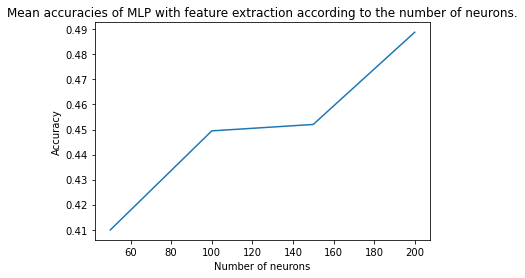

In [6]:
    LS_path = os.path.join(DATA_PATH, 'LS')   
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    
    iter_nb = 5
    
    ids = [1, 2, 3, 4, 5]
    learning_id = [0, 0, 0]   
    scores = np.zeros(iter_nb)
    
    random.seed()
    
    learning_id = [0,0,0]
    
    gen_score = []
    number_neurons = []
    
    for x in range(50, 250, 50):
        for j in range(iter_nb):
            random.shuffle(ids)

            for i in range(3):
                learning_id[i] = ids[i]

            unique_ls, count_ls = np.unique(LS_subject_id, return_counts = True)

            count = np.asarray((unique_ls, count_ls))

            training_size = int(count[1][learning_id[0] - 1] + count[1][learning_id[1] - 1] + count[1][learning_id[2] - 1])

            X_train_split = np.zeros((training_size, X_train.shape[1]))
            X_test_split = np.zeros((3500 - training_size, X_test.shape[1]))

            y_train_split = np.zeros((training_size))
            y_test_split = np.zeros((3500 - training_size))

            training_current_size, testing_current_size = 0, 0

            for i in range(3500):
                if LS_subject_id[i] in learning_id:
                    X_train_split[training_current_size] = X_train[i]
                    y_train_split[training_current_size] = y_train[i]
                    training_current_size += 1
                else:
                    X_test_split[testing_current_size] = X_train[i]
                    y_test_split[testing_current_size] = y_train[i]
                    testing_current_size += 1

            rf = MLPClassifier(random_state = 0, hidden_layer_sizes = (x,)).fit(X_train_split, y_train_split)
            y_pred = rf.predict(X_test_split)
            scores[j] = accuracy_score(y_test_split, y_pred)

        gen_score.append(np.mean(scores))
        number_neurons.append(x)
              
    plt.plot(number_neurons, gen_score)
    plt.xlabel("Number of neurons")
    plt.ylabel("Accuracy")
    plt.title("Mean accuracies of MLP with feature extraction according to the number of neurons.")
    plt.savefig('MLP_feature_extraction_neurons.png')
    plt.show()

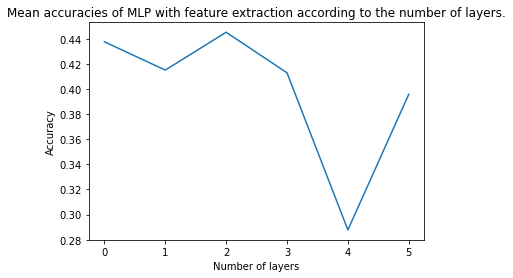

In [7]:
    LS_path = os.path.join(DATA_PATH, 'LS')   
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    
    iter_nb = 5
    
    ids = [1, 2, 3, 4, 5]
    learning_id = [0, 0, 0]   
    scores = np.zeros(iter_nb)
    
    random.seed()
    
    learning_id = [0,0,0]
    
    gen_score = []
    number_layers = []
    layers = [50]
    
    for x in range(6):
        for j in range(iter_nb):
            random.shuffle(ids)

            for i in range(3):
                learning_id[i] = ids[i]

            unique_ls, count_ls = np.unique(LS_subject_id, return_counts = True)

            count = np.asarray((unique_ls, count_ls))

            training_size = int(count[1][learning_id[0] - 1] + count[1][learning_id[1] - 1] + count[1][learning_id[2] - 1])

            X_train_split = np.zeros((training_size, X_train.shape[1]))
            X_test_split = np.zeros((3500 - training_size, X_test.shape[1]))

            y_train_split = np.zeros((training_size))
            y_test_split = np.zeros((3500 - training_size))

            training_current_size, testing_current_size = 0, 0

            for i in range(3500):
                if LS_subject_id[i] in learning_id:
                    X_train_split[training_current_size] = X_train[i]
                    y_train_split[training_current_size] = y_train[i]
                    training_current_size += 1
                else:
                    X_test_split[testing_current_size] = X_train[i]
                    y_test_split[testing_current_size] = y_train[i]
                    testing_current_size += 1

            rf = MLPClassifier(random_state = 0, hidden_layer_sizes = layers).fit(X_train_split, y_train_split)
            y_pred = rf.predict(X_test_split)
            scores[j] = accuracy_score(y_test_split, y_pred)

        gen_score.append(np.mean(scores))
        number_layers.append(x)
        layers.append(50)
              
    plt.plot(number_layers, gen_score)
    plt.xlabel("Number of layers")
    plt.ylabel("Accuracy")
    plt.title("Mean accuracies of MLP with feature extraction according to the number of layers.")
    plt.savefig('MLP_feature_extraction_layers.png')
    plt.show()